# Final Project Submission
* Student name: James M. Irivng, Ph.D.
* Student pace: full time
* Scheduled project review date/time: 05/15/19 2:30 pm
* Instructor name: Jeff Herman / Brandon Lewis
* Blog post URL:


# Iowa Prisoner Recidivism

<img src="images/LSA_map_with_counties_districts_and_B54A5BBCE4156.jpg" width=80%>

## Data Source: Iowa Department of Corrections 

- Source: https://www.kaggle.com/slonnadube/recidivism-for-offenders-released-from-prison
- **Statistics about recidivism in prisoners from a 3 year prisoner**
- **Target:**
    - Recidivism - Return to Prison
- **Features:**
    - Fiscal Year Released
    - Recidivism Reporting Year
    - Race - Ethnicity
    - Age At Release
    - Convicting Offense Classification
    - Convicting Offense Type
    - Convicting Offense Subtype
    - Main Supervising District
    - Release Type
    - Release type: Paroled to Detainder united
    - Part of Target Population

### Detailed variable descriptions:

- **Fiscal Year Released**
    - Fiscal year (year ending June 30) for which the offender was released from prison.

- **Recidivism Reporting Year**
    - Fiscal year (year ending June 30) that marks the end of the 3-year tracking period. For example, offenders exited prison in FY 2012 are found in recidivism reporting year FY 2015.

- **Race - Ethnicity**
    - Offender's Race and Ethnicity

- **Convicting Offense Classification**
    - Maximum penalties: A Felony = Life; B Felony = 25 or 50 years; C Felony = 10 years; D Felony = 5 years; Aggravated Misdemeanor = 2 years; Serious Misdemeanor = 1 year; Simple Misdemeanor = 30 days

- **Convicting Offense Type**
    - General category for the most serious offense for which the offender was placed in prison.

- **Convicting Offense Subtype**
    - Further classification of the most serious offense for which the offender was placed in prison.

- **Release Type**
    - Reasoning for Offender's release from prison.

- **Main Supervising District**
    - The Judicial District supervising the offender for the longest time during the tracking period.

- **Recidivism - Return to Prison**
    - No = No Recidivism; Yes = Prison admission for any reason within the 3-year tracking period
    
- **Part of Target Population** 
    - The Department of Corrections has undertaken specific strategies to reduce recidivism rates for prisoners who are on parole and are part of the target population.
    ___

# USING THE OSEMN MODEL TO GUIDE WORKFLOW

1. **OBTAIN:**
    - [x] Import data, inspect, check for datatypes to convert and null values
<br><br>

2. **SCRUB: cast data types, identify outliers, check for multicollinearity, normalize data**<br>
    - Check and cast data types
    - [x] Check for missing values 
    - [x] Check for multicollinearity
    - [x] Normalize data (may want to do after some exploring)   
    <br><br>
            
3. **EXPLORE:Check distributions, outliers, etc**
    - [x] Check scales, ranges (df.describe())
    - [x] Check histograms to get an idea of distributions (df.hist()) and data transformations to perform
    - [x] Use scatterplots to check for linearity and possible categorical variables (df.plot(kind-'scatter')
    <br><br>

   
4. **FIT AN INITIAL MODEL:** 
    - [x] Assess the model.
        <br><br>
5. **REVISE THE FITTED MODEL**
    - [x] Adjust chosen model and hyper-parameters
    <br><br>
6. **HOLDOUT VALIDATION**
    - [ ] Perform cross-validation
___

# OBTAIN:

### Using Custom PyPi Package - `fsds`


In [1]:
import bs_ds_local as bs

In [2]:
# !pip install -U fsds
from fsds.imports import *

fsds v0.2.25 loaded.  Read the docs: https://fs-ds.readthedocs.io/en/latest/ 


Handle,Package,Description
dp,IPython.display,Display modules with helpful display and clearing commands.
fs,fsds,Custom data science bootcamp student package
mpl,matplotlib,Matplotlib's base OOP module with formatting artists
plt,matplotlib.pyplot,Matplotlib's matlab-like plotting module
np,numpy,scientific computing with Python
pd,pandas,High performance data structures and tools
sns,seaborn,High-level data visualization library based on matplotlib


[i] Pandas .iplot() method activated.


In [3]:
## Set Pandas Options
pd_options = {
    'display.max_rows'    : 200,
    'display.max_info_rows':200,
    'display.max_columns' : 0,
#     'display.float_format':'${:,.2f}'.format
}
[pd.set_option(option, setting) for option, setting in pd_options.items()]


## Set Plot Style
plt.style.use('dark_background')

## Suppress Warnings
import warnings
warnings.filterwarnings

<function warnings.filterwarnings(action, message='', category=<class 'Warning'>, module='', lineno=0, append=False)>

In [4]:
import bs_ds_local as bs

## Loading the dataset and removing unrelated columns

In [5]:
ls data/

3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv
Iowa_recidivism_features_cleaned_2020.csv
iowa_recidivism_renamed_2020.csv


In [6]:
df = pd.read_csv('data/3-Year_Recidivism_for_Offenders_Released_from_Prison_in_Iowa.csv')
df

,Fiscal Year Released,Recidivism Reporting Year,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Days to Return,Recidivism Type,New Offense Classification,New Offense Type,New Offense Sub Type,Target Population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,433.0,New,C Felony,Drug,Trafficking,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,453.0,Tech,NaN,NaN,NaN,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,832.0,Tech,NaN,NaN,NaN,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,116.0,Tech,NaN,NaN,NaN,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26015,2015,2018,NaN,Paroled to Detainer - INS,White - Hispanic,Under 25,Male,C Felony,Violent,Assault,No,NaN,No Recidivism,NaN,NaN,NaN,Yes
26016,2015,2018,6JD,Released to Special Sentence,White - Non-Hispanic,35-44,Male,C Felony,Violent,Sex,No,NaN,No Recidivism,NaN,NaN,NaN,No
26017,2015,2018,5JD,Parole Granted,White - Non-Hispanic,25-34,Female,Aggravated Misdemeanor,Public Order,Traffic,No,NaN,No Recidivism,NaN,NaN,NaN,No
26018,2015,2018,5JD,Paroled w/Immediate Discharge,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,No,NaN,No Recidivism,NaN,NaN,NaN,Yes


**Any columns that are about New Convictions or days to recidivism should be dropped for our initial model predicting recidivism.**
- "New..", "Days to Recividism"

In [7]:
## Drop cols related to recivism details 
drop_expr = ['New',"Days","Recidivism Type"]

drop_cols = []
for exp in drop_expr:
    drop_cols.extend([col for col in df.columns if exp in col])
    
df.drop(columns=drop_cols,inplace=True)
df.head()

,Fiscal Year Released,Recidivism Reporting Year,Main Supervising District,Release Type,Race - Ethnicity,Age At Release,Sex,Offense Classification,Offense Type,Offense Subtype,Return to Prison,Target Population
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,No


### Save original names vs short names in column_legend
- then map names onto columns

In [8]:
## Replacing columns with short names
rename_map = {
    'Fiscal Year Released': 'yr_released',
    'Recidivism Reporting Year': 'report_year' ,
    'Main Supervising District': 'supervising_dist' ,
    'Release Type': 'release_type' ,
    'Race - Ethnicity': 'race_ethnicity'  ,
    'Age At Release ':  'age_released' ,
    'Sex':'sex'   ,
    'Offense Classification': 'crime_class' ,
    'Offense Type': 'crime_type'  ,
    'Offense Subtype':  'crime_subtype' ,
    'Return to Prison': 'recidivist'  ,
    'Target Population':  'target_pop'
}

df = df.rename(rename_map,axis=1)
df

,yr_released,report_year,supervising_dist,release_type,race_ethnicity,age_released,sex,crime_class,crime_type,crime_subtype,recidivist,target_pop
0,2010,2013,7JD,Parole,Black - Non-Hispanic,25-34,Male,C Felony,Violent,Robbery,Yes,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,Yes,No
2,2010,2013,5JD,Parole,White - Non-Hispanic,35-44,Male,B Felony,Drug,Trafficking,Yes,Yes
3,2010,2013,6JD,Parole,White - Non-Hispanic,25-34,Male,B Felony,Other,Other Criminal,No,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black - Non-Hispanic,35-44,Male,D Felony,Violent,Assault,Yes,No
...,...,...,...,...,...,...,...,...,...,...,...,...
26015,2015,2018,NaN,Paroled to Detainer - INS,White - Hispanic,Under 25,Male,C Felony,Violent,Assault,No,Yes
26016,2015,2018,6JD,Released to Special Sentence,White - Non-Hispanic,35-44,Male,C Felony,Violent,Sex,No,No
26017,2015,2018,5JD,Parole Granted,White - Non-Hispanic,25-34,Female,Aggravated Misdemeanor,Public Order,Traffic,No,No
26018,2015,2018,5JD,Paroled w/Immediate Discharge,White - Non-Hispanic,25-34,Male,D Felony,Property,Theft,No,Yes


In [9]:
df.to_csv('data/iowa_recidivism_renamed_2020.csv')

# SCRUB / EXPLORE


In [10]:
## Explore Dtypes and info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26020 entries, 0 to 26019
Data columns (total 12 columns):
 #   Column            Dtype 
---  ------            ----- 
 0   yr_released       int64 
 1   report_year       int64 
 2   supervising_dist  object
 3   release_type      object
 4   race_ethnicity    object
 5   age_released      object
 6   sex               object
 7   crime_class       object
 8   crime_type        object
 9   crime_subtype     object
 10  recidivist        object
 11  target_pop        object
dtypes: int64(2), object(10)
memory usage: 2.4+ MB


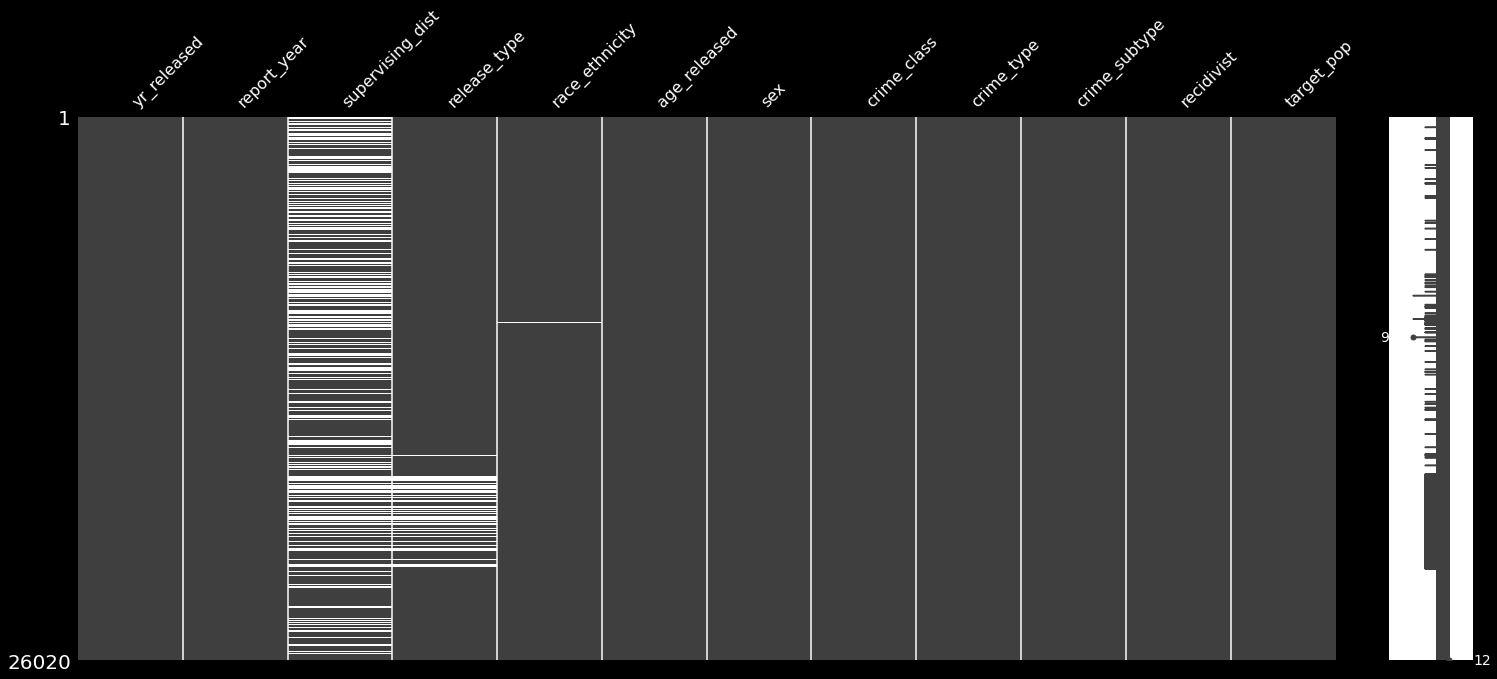

,#,%
supervising_dist,9581,36.820000
release_type,1762,6.770000
race_ethnicity,30,0.120000
age_released,3,0.010000
sex,3,0.010000


In [11]:
import missingno as ms


def nulls_report(df):
    nulls= df.isna().sum()
    nulls_only = nulls[nulls>0].to_frame('#')
    nulls_only['%'] = ((nulls_only['#']/len(df))*100)
    nulls_only = nulls_only.round(2)
    capt='Columns with Null Values:'
    display(nulls_only.style.set_caption(capt))
ms.matrix(df)
plt.show()
  
    
nulls_report(df)


**Results of Null Check**
- race_ethnicity has 30 (0.12% of data)
    -  drop
- age_released has 3 (0.01% of data)
    - drop
- sex has 3 (0.01% of data)
    - drop
- super_district has 9581(36.82% of data)
    - replace with "unknown"
- release_type has 1762 (6.77% of data)
    - drop
    
**Dropping all null values from age_released, race_ethnicity, and release_type.**

## SIMPLIFYING CATEGORICAL FEATURES

### Making `age_released` numerical

In [12]:
def value_counts(col,dropna=False,normalize=True):
    """Convenience function for display value counts with default params"""
    return col.value_counts(dropna=dropna,normalize=normalize)

In [13]:
value_counts(df['age_released'])#.value_counts(dropna=False)

25-34           0.367179
35-44           0.239162
Under 25        0.176403
45-54           0.167064
55 and Older    0.050077
NaN             0.000115
Name: age_released, dtype: float64

In [14]:
# Mapping age_map onto 'age_released'
# Encoding age groups as ordinal
age_ranges = ('Under 25','25-34', '35-44','45-54','55 and Older')
age_numbers = (20,30,40,50,70) 
age_num_map = dict(zip(age_ranges,age_numbers))
age_num_map

{'Under 25': 20, '25-34': 30, '35-44': 40, '45-54': 50, '55 and Older': 70}

In [15]:
df['age_released'] = df['age_released'].map(age_num_map)
value_counts(df['age_released'])

30.0    0.367179
40.0    0.239162
20.0    0.176403
50.0    0.167064
70.0    0.050077
NaN     0.000115
Name: age_released, dtype: float64

### df['race_ethnicity']

In [16]:
value_counts(df['race_ethnicity'])

White - Non-Hispanic                               0.675788
Black - Non-Hispanic                               0.234781
White - Hispanic                                   0.058493
American Indian or Alaska Native - Non-Hispanic    0.019293
Asian or Pacific Islander - Non-Hispanic           0.007379
Black - Hispanic                                   0.001422
NaN                                                0.001153
American Indian or Alaska Native - Hispanic        0.000769
White -                                            0.000461
N/A -                                              0.000192
Asian or Pacific Islander - Hispanic               0.000192
Black -                                            0.000077
Name: race_ethnicity, dtype: float64

- **Remapping race_ethnicity**
    - Due to the low numbers for several of the race_ethnicity types, reducing and combining Hispanic and Non-Hispanic groups
    - Alternative approach of separating race and ethnicity into 2 separate features was rejected after modeling

In [17]:
# Defining Dictionary Map for race_ethnicity categories
race_ethnicity_map = {'White - Non-Hispanic':'White',
                        'Black - Non-Hispanic': 'Black',
                        'White - Hispanic' : 'Hispanic',
                        'American Indian or Alaska Native - Non-Hispanic' : 'American Native',
                        'Asian or Pacific Islander - Non-Hispanic' : 'Asian or Pacific Islander',
                        'Black - Hispanic' : 'Black',
                        'American Indian or Alaska Native - Hispanic':'American Native',
                        'White -' : 'White',
                        'Asian or Pacific Islander - Hispanic' : 'Asian or Pacific Islander',
                        'N/A -' : np.nan,
                        'Black -':'Black'}

# Replacing original race_ethnicity column with remapped one.
df['race_ethnicity'] = df['race_ethnicity'].map(race_ethnicity_map)
value_counts(df['race_ethnicity'])

White                        0.676249
Black                        0.236280
Hispanic                     0.058493
American Native              0.020061
Asian or Pacific Islander    0.007571
NaN                          0.001345
Name: race_ethnicity, dtype: float64

### df['crime_class']

- **Remapping crime_class**
    - Combine 'Other Felony' and 'Other Felony (Old Code)' -> nan
    - Other Misdemeanor -> np.nan
    - Felony - Mandatory Minimum -> np.nan
    - Special Sentence 2005 -> Sex Offender
    - 'Sexual Predator Community Supervision' -> 'Sex Offender'
    - Other Felony -> np.nan    

In [18]:
value_counts(df['crime_class'])

D Felony                                    0.403036
C Felony                                    0.261453
Aggravated Misdemeanor                      0.189470
B Felony                                    0.067832
Felony - Enhancement to Original Penalty    0.058916
Felony - Enhanced                           0.008455
Serious Misdemeanor                         0.005957
Special Sentence 2005                       0.003766
Felony - Mandatory Minimum                  0.000423
Other Felony                                0.000231
A Felony                                    0.000154
Simple Misdemeanor                          0.000115
Sexual Predator Community Supervision       0.000077
Other Felony (Old Code)                     0.000077
Other Misdemeanor                           0.000038
Name: crime_class, dtype: float64

In [19]:
# Remapping
crime_class_map = {'Other Felony (Old Code)':'Other Felony' ,#or other felony
                  'Other Misdemeanor':'Other Misdemeanor',
                   'Felony - Mandatory Minimum':'Other Felony',#np.nan, # if minimum then lowest sentence ==  D Felony
                   'Special Sentence 2005': 'Sex Offender',
                   'Other Felony' : 'Other Felony' ,
                   'Sexual Predator Community Supervision' : 'Sex Offender',
                   'D Felony': 'D Felony',
                   'C Felony' :'C Felony',
                   'B Felony' : 'B Felony',
                   'A Felony' : 'A Felony',
                   'Aggravated Misdemeanor':'Aggravated Misdemeanor',
                   'Felony - Enhancement to Original Penalty':'Felony - Enhanced',
                   'Felony - Enhanced':'Felony - Enhanced' ,
                   'Serious Misdemeanor':'Serious Misdemeanor',
                   'Simple Misdemeanor':'Simple Misdemeanor'}

df['crime_class'] = df['crime_class'].map(crime_class_map)
value_counts(df['crime_class'])

D Felony                  0.403036
C Felony                  0.261453
Aggravated Misdemeanor    0.189470
B Felony                  0.067832
Felony - Enhanced         0.067371
Serious Misdemeanor       0.005957
Sex Offender              0.003843
Other Felony              0.000730
A Felony                  0.000154
Simple Misdemeanor        0.000115
Other Misdemeanor         0.000038
Name: crime_class, dtype: float64

### Remapping target

In [20]:
# Recidivist
df['recidivist'] = df['recidivist'].map( {'No':0,'Yes':1})
value_counts(df['recidivist'])

0    0.666372
1    0.333628
Name: recidivist, dtype: float64

In [21]:
df.head()

,yr_released,report_year,supervising_dist,release_type,race_ethnicity,age_released,sex,crime_class,crime_type,crime_subtype,recidivist,target_pop
0,2010,2013,7JD,Parole,Black,30.0,Male,C Felony,Violent,Robbery,1,Yes
1,2010,2013,NaN,Discharged – End of Sentence,White,30.0,Male,D Felony,Property,Theft,1,No
2,2010,2013,5JD,Parole,White,40.0,Male,B Felony,Drug,Trafficking,1,Yes
3,2010,2013,6JD,Parole,White,30.0,Male,B Felony,Other,Other Criminal,0,Yes
4,2010,2013,NaN,Discharged – End of Sentence,Black,40.0,Male,D Felony,Violent,Assault,1,No


___
## FEATURE ENGINEERING
- **Engineering a simple 'felony' true false category**
- **Combining crime_type and crime_subtype into types_combined**

### Creating a simple 'felony' feature

In [22]:
# Engineering a simple 'felony' true false category
df['felony'] = df['crime_class'].str.contains('felony',case=False)
value_counts(df['felony'])

True     0.800576
False    0.199424
Name: felony, dtype: float64

In [23]:
# df['crime_types_combined'] = df['crime_type']+'_'+df['crime_subtype']
# value_counts(df['crime_types_combined'])

In [24]:
# Combining crime_type and crime_subtype into types_combined
# df['crime_class_type_subtype']= df['crime_class']+'_'+df['crime_type']+'_'+df['crime_subtype']
# value_counts(df['crime_class_type_subtype'])
df.nunique()

yr_released          6
report_year          6
supervising_dist    10
release_type        12
race_ethnicity       5
age_released         5
sex                  2
crime_class         11
crime_type           5
crime_subtype       26
recidivist           2
target_pop           2
felony               2
dtype: int64

### Creating a 'max_sentence' feature based on crime class max penalties
   

In [25]:
# Mapping years onto crime class
crime_class_max_sentence_map = {'A Felony': 75,  # Life
                                'Aggravated Misdemeanor': 2, # 2 years
                                'B Felony': 50, # 25 or 50 years
                                'C Felony': 10, # 10 years
                                'D Felony': 5,  # 5 yeras
                                'Felony - Enhanced': 10, # Add on to class C and D felonies, hard to approximate. 
                                'Serious Misdemeanor': 1, # 1 year
                                'Sex Offender': 10, # 10 years
                                'Simple Misdemeanor': 0.83} # 30 days

# Mapping max_sentence_column
df['max_sentence'] =df['crime_class'].map(crime_class_max_sentence_map)
value_counts(df['max_sentence'])

5.00     0.403036
10.00    0.332667
2.00     0.189470
50.00    0.067832
1.00     0.005957
NaN      0.000769
75.00    0.000154
0.83     0.000115
Name: max_sentence, dtype: float64

### Dropping all  values replaced with np.nan

In [28]:
nulls_report(df)

,#,%
supervising_dist,9581,36.820000
release_type,1762,6.770000
race_ethnicity,35,0.130000
age_released,3,0.010000
sex,3,0.010000
max_sentence,20,0.080000


# BOOKMARK

In [ ]:
stop

In [26]:
# check_null(df)

In [ ]:
# 


In [27]:
# df.to_csv('Iowa_recidivism_features_pre-processing.csv')

## Processing Chosen Feature Columns

In [ ]:
# List of features to be analyzed as categories
category_cols = ['yr_released','race_ethnicity', 'crime_class',
                 'release_type','crime_type','crime_subtype',
                 'target_pop','sex','super_dist','felony']

# List of features to be analzyed as numbers
number_cols = ['max_sentence','age_released']

# Target feature
target_col = ['recidivist']

In [ ]:
# Creating new dataframe ('df_to_split') to contain processed features for train_test_split
df_to_split=pd.DataFrame()

# MinMaxing Numerical Columns
from sklearn.preprocessing import MinMaxScaler
sca = MinMaxScaler()

for header in number_cols:
    print(header)
    data = np.array(df[header])
    res = sca.fit_transform(data.reshape(-1,1))
    df_to_split[header] = res.ravel()    

In [ ]:
# Convert categories to cat.codes
for header in category_cols:
    df_to_split[header] = df[header].astype('category').cat.codes
    
df_to_split.info()

### Using SHAP values to explain model

# CONCLUSIONS
- **After adjusting for imbalanced classes, the most important factor for determining recidivism are:**
    - **Age at Release**
    - **Supervising Judicial District**
    - **Release Type**
    - **Crime Subtype**
    
    
## Recommendatons
- This model could be used to predict which prisoners due for release may at the greatest risk for recidivism.<br><br>
    - Using this knowledge, the state of Iowa could put new programs into action that target those at high risk for recidivism and provide additional assistance and guidance following release.<br><br>
    - Additionally, there could be additional counseling or education _prior_ to release to supply the inmate with tools and options to avoid returning to a life of crime.
    
# FUTURE DIRECTIONS
- With more time and reliable performance, would perform cross-validation of our final model.<br><br>
- Additional visuals summarizing the underlying features effects on recidivism.<br><br>
- Adapting more available visualization tools to better display the underpinning of the model.
<br><br>
- Exploration of the predictability of crimes types committed by recidivists.

### POST-REVIEW SUGGESTIONS / IDEAS:
- [ ] Try using reduction instead of SMOTE.
- [ ] seaborn catplot bar graphs
- [ ] Add tree or other visuals
    - Try Mike's SHAP plots

In [ ]:
from bs_ds import viz_tree

In [ ]:
viz_tree(cb_clf)

In [ ]:
compare_tree = sklearn.tree.DecisionTreeClassifier()
dir(compare_tree)

In [ ]:
compare_tree.fit(X_train, y_train)

In [ ]:
dir(compare_tree)

In [ ]:
# This is the tree object that sklearn generates and is looking for 
help(compare_tree.tree_)

In [ ]:
dir(cb_clf)

In [ ]:
help(cb_clf.get_metadata())

In [ ]:
test = cb_clf.get_metadata()

In [ ]:
help(cb_clf)

### SHAP values
https://github.com/jirvingphd/shap


In [ ]:
import shap
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(cb_clf)

In [ ]:
shap_vals = explainer.shap_values(train_pool)

In [ ]:
shap.force_plot(explainer.expected_value, shap_vals[:1000],X_train[:1000])

In [ ]:
shap.summary_plot(shap_vals, X_train)

In [ ]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")